In [1]:
import numpy as np
import sklearn
import math
import sklearn.datasets
from sklearn.model_selection import train_test_split
from planar import *
import matplotlib.pyplot as plt

In [2]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

In [3]:
def initalize_parameter(layer_dims=[], initalization_method="He"):
    L = len(layer_dims)
    parameters = {}

    for i in range(1, L):
        shape = (layer_dims[i], layer_dims[i - 1])
        if initalization_method == "He":
            parameters["W" + str(i)] = np.random.randn(shape[0], shape[1]) * np.sqrt(
                2 / shape[1]
            )
            parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
        else:
            parameters["W" + str(i)] = np.random.randn(shape[0], shape[1]) * 0.01
            parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
    # for i in range(1, L):
    #     x, y = parameters["W" + str(i)].shape
    #     print(f"W {str(i)} ({x}, {y})")
    return parameters


In [4]:
def relu_forward(x):
    b = (np.where(x > 0, x, x * 0.01), x)
    return b


def relu_backward(dA, Z):
    dx = np.ones_like(Z)
    dx[Z < 0] = 0.01
    return dA * dx


def sigmoid_forward(x):
    s = 1 / (1 + np.exp(-x))
    c = (s, x)
    return c


def tanh_forward(z):
    d = (np.tanh(z), z)
    return d


def tanh_backward(z):
    return 1


def sigmoid_backward(dA, cache):
    Z = cache
    s, _ = sigmoid_forward(Z)
    dZ = dA * (s * (1 - s))
    return dZ


def softmax_layer(z, c):
    return z

In [5]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_method):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation_method == "Relu":
        A, activation_cache = relu_forward(Z)
    elif activation_method == "Sigmoid":
        A, activation_cache = sigmoid_forward(Z)
    else:
        A, activation_cache = tanh_forward(Z)
    cache = (linear_cache, activation_cache)
    return A, cache


def forward_propagation(mini_batch_X, layers, parameters):
    caches = []
    A = mini_batch_X
    L = len(parameters) // 2
    for l in range(1, L + 1):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev,
            parameters["W" + str(l)],
            parameters["b" + str(l)],
            layers[l - 1]["activation"],
        )
        caches.append(cache)
    return A, caches

In [6]:
def linear_backward(dZ, cache, m):
    A_prev, W, _ = cache
    dW = 1 / m * (np.dot(dZ, A_prev.T))
    db = 1 / m * (np.sum(dZ, axis=1, keepdims=True))
    dA_Prev = np.dot(W.T, dZ)
    # print(dA_Prev.shape)
    return (
        dA_Prev,
        dW,
        db,
    )


def linear_activation_backward(dA, cache, activation_method, m):
    linear_cache, activation_cache = cache
    if activation_method == "Relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation_method == "Sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    else:
        dZ = tanh_backward(activation_cache)
    return linear_backward(dZ, linear_cache, m)


def back_propagation(AL, Y, caches, layers):
    # assert(len(caches) == len(layers))
    grads = {}
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dA_prev = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # print(dA_prev.shape)
    # print("")
    L = len(layers)
    for l in reversed(range(1, L + 1)):
        dA = dA_prev
        (
            dA_prev,
            grads["dW" + str(l)],
            grads["db" + str(l)],
        ) = linear_activation_backward(
            dA, caches[l - 1], layers[l - 1]["activation"], m
        )
    return grads


def update_parameters(grads, params, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]
    return parameters

In [7]:
def compute_cost(AL, Y, m):

    logprobs = np.multiply(np.log(AL),Y)  + np.multiply(np.log(1-AL),1-Y)
    cost = - 1/m * np.sum(logprobs)  
    return cost


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()


def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [8]:
class Model:
    layers = []
    inputs = np.array([])
    outputs = np.array([])
    parameters = {}
    grads = {}

    def __init__(self, inputs, outputs):
        self.inputs = np.array(inputs, dtype=np.float128)
        self.outputs = np.array(outputs, dtype=np.float128)
        assert self.inputs.shape[1] == self.outputs.shape[1]
        self.parameters = {}
        self.grads = {}

    def get_layer_dims(self):
        n_x = self.inputs.shape[0]
        layers_dim = [n_x]
        for i in self.layers:
            layers_dim.append(int(i["hidden_unit"]))
        return layers_dim

    def add_layer(self, layer_params):
        self.layers.append(layer_params)
        return self

    def batchify(self, mini_batch_size=64):
        mini_batches = []
        m = self.inputs.shape[1]
        # randomize = np.arange(m)
        # np.random.shuffle(randomize)
        shuffled_X = self.inputs
        shuffled_Y = self.outputs
        # print(shuffled_X.shape)
        num_of_batches = math.floor(m / mini_batch_size)
        for k in range(0, num_of_batches):
            z = k * mini_batch_size
            mini_batch_X = shuffled_X[:, z : z + mini_batch_size]
            mini_batch_Y = shuffled_Y[:, z : z + mini_batch_size]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        if m % mini_batch_size != 0:
            all_x = num_of_batches * mini_batch_size
            mini_batch_X = shuffled_X[:, all_x:]
            mini_batch_Y = shuffled_Y[:, all_x:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        return mini_batches

    def train(
        self,
        batch_size=400,
        epoch=100000,
        learning_rate=0.5,
        lr_decay=True,
        decay_rate=1,
        initalization_method="He",
    ):
        mini_batches = self.batchify(batch_size)
        layer_dims = self.get_layer_dims()
        # print(layer_dims)
        self.parameters = initalize_parameter(layer_dims, initalization_method)
        for i in range(epoch):
            logs = {}
            for mini_batch in mini_batches:
                (mini_batch_X, mini_batch_Y) = mini_batch
                # print(mini_batch_X.shape)
                AL, caches = forward_propagation(
                    mini_batch_X, self.layers, self.parameters
                )
                assert AL.shape == mini_batch_Y.shape
                cost = compute_cost(AL, mini_batch_Y, batch_size)
                grads = back_propagation(AL, mini_batch_Y, caches, self.layers)
                if lr_decay:
                    learning_rate = (1 / (1 + decay_rate * i)) ** learning_rate

                self.parameters = update_parameters(
                    grads, self.parameters, learning_rate
                )
                accuracy = get_accuracy_value(AL, mini_batch_Y)
                if i % 100 == 0:
                    logs = {"loss": cost, "acc": accuracy}
                    # liveloss.update(logs)
                    # liveloss.send()

        return self

    def predict(self, inputs, outputs=None):
        AL, cache = forward_propagation(inputs, self.layers, self.parameters)
#         accuracy = get_accuracy_value(AL, outputs)
#         print(f"Accuracy: {accuracy * 100}")
        return convert_prob_into_class(AL)


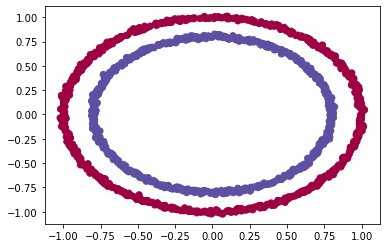

In [26]:
X, Y = sklearn.datasets.make_circles(n_samples=1500, noise=0.01)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2)
train_X = train_X.T
train_Y = train_Y.reshape(1, train_X.shape[1])
test_X = test_X.T
test_Y = test_Y.reshape(1, test_X.shape[1])
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);

In [25]:
neural_net = (
    Model(train_X, train_Y)
    .add_layer({"hidden_unit": 6, "activation": "Relu"})
    .add_layer({"hidden_unit": 6, "activation": "Relu"})
    .add_layer({"hidden_unit": 6, "activation": "Relu"})
    .add_layer({"hidden_unit": 6, "activation": "Relu"})
    .add_layer({"hidden_unit": 1, "activation": "Sigmoid"})
    .train(initalization_method="He", epoch=2000, learning_rate=1, batch_size=64)
)

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

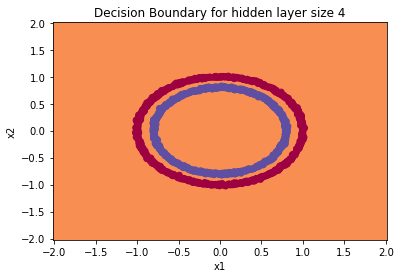

In [27]:
# Build a model with a n_h-dimensional hidden layer


# Plot the decision boundary
plot_decision_boundary(lambda x: neural_net.predict(x.T), train_X, train_Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [11]:
x = np.array([[ True , False, True]])
print(x.shape)

(1, 3)
